# Tutorial 2: Surrogate modelling with Kriging

A major issue in Uncertainty Quantification is the high-cost of evaluating the computational model one time (e.g. a CFD code) - combined with the large number of evaluations needed.  *Surrogate modelling* is a general term, describing replacing the CFD code with a cheap map that approximates it.  The polynomial stochastic methods are also surrogate models when used for interpolation (as opposed to quadrature).

With $d \in\mathbb{N}$ the number of parameters (the *dimension*), and a scalar output, any simulation code $g(\cdot)$ is schematically:
$$
g: \mathbb{R}^d\rightarrow \mathbb{R}
$$
to be approximated by a surrogate model $\hat g(\cdot)$:
$$
g(\mathbf{x}) \simeq \hat g(\mathbf{x}),\quad \mathbf{x}\in\Omega \subset \mathbb{R}^d.
$$

Surrogate models can be interpolative or regressive.  Some examples:

* Stochastic polynomial interpolants, including sparse-grids;
* Linear regression;
* Radial-basis function interpolation.

Our goal in this tutorial is to implement and explore the *stochastic* regressive surrogate model $\hat g$ called variously "Kriging" (by engineers) or "Gaussian Process Regression" (by mathematicians).  For simplicity will will consider the case $d=1$, but the generalization to higher-dimensions is striaghtforward.

We will consider the test-function
$$
g(x) = \sin(cx^2)\cdot (1+x) + (1+x^2),\quad c=40,
$$

In [345]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.stats as stats

c = 40
def g(x): return np.sin(x*x*c)*(1+x) + (1+x**2)

g-Mean: 1.4651525789495015, g-StdDev: 1.082548228747729


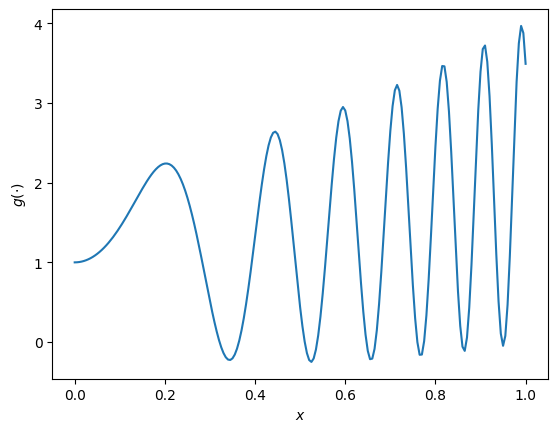

In [347]:
x = np.linspace(0, 1, 201)
plt.plot(x, g(x), '-')
plt.xlabel(r'$x$'); plt.ylabel(r'$g(\cdot)$')

g_mean = np.mean(g(x))
g_std = np.std(g(x))

print(f'g-Mean: {g_mean}, g-StdDev: {g_std}')

## Discretizing the domain $\Omega$
**EXERCISE 1**

Generate about $M=10$ *training nodes* randomly on $\Omega = [0,1]$ (e.g. with `np.random.rand()`), and additionally about $N=100$ *test nodes* uniformly spaced on $\Omega = [0,1]$.  Concatenate these arrays (e.g. with `np.hstack()`) to get a single array of both training and test nodes, "all".  To check your code `x_all.shape == (M+N,)` should be `True`.

In [349]:
M = 10
N = 100

x_train = np.random.rand(M)
x_test = np.random.rand(N)
x_all = np.hstack((x_train, x_test))

assert x_all.shape == (M+N,)

## Sampling from the prior

The first step is computing the prior covariance matrix based on the definition in the notes:
$$
[P]_{ij} := \sigma_y^2 r(x_i, x_j, l),\quad r(x_i,x_j,l) := \exp\left\{-\frac{|x_i-x_j|^2}{2 l^2}\right\}
$$
In the following code `r()` with array arguments `xi` and `xj`, computes the function $r()$ above, for all combinations of array entries, and returns the result in a matrix. 

In [351]:
def distances_all(xi,xj): 
    return np.abs(xi[np.newaxis,:] - xj[:,np.newaxis])

def r(xi, xj, sigma_0, l): 
    return sigma_0**2 * np.exp(-distances_all(xi,xj)**2/ l**2)

**EXERCISE 2**

Consider the Gaussian process $\mathcal{Y}_0$ defined by some mean function $\mu(x)$ and $r()$, written:
$$
\mathcal{Y}_0 \sim \mathcal{GP}(\mu, r).
$$
We know from the lectures that by selecting a finite vector of nodes $\mathbf{x} = (x_1,\dots,x_N)$, we can define a multivariate random variable $\mathbf{Y}_0$:
$$
\mathbf{Y}_0 = \mathcal{Y}(\mathbf{x}) \sim \mathcal{N}(\mu(\mathbf{x}), P)
$$
Define a function `mu(x)`, and using this and the previously defined `r()`, generate random samples from $\mathbf{Y}_0$ for your *test nodes* only.

[Note: Use `scipy.stats.multivariate_normal()` with the parmeter `allow_singular=True` to surpress errors and warnings.  This is a numerical conditioning issue, due to floating-point accuracy - and does not result in any problems in this notebook.  Generating (e.g. 10) samples can be done with `scipy.stats.multivariate_normal(mu,P).rvs(10)`]

Plot a few (e.g. 10-20) samples of $\mathbf{Y}_0$ (each sample is a function).  Explore the effects of $\mu$, $\sigma_0$ and $l$ on the functions generated.  Do you think one of the *class* of functions generated would be a good fit for $g$?  Find parameters that you think represent a reasonable *prior* for $g()$.

---

Periodic *class* of functions well-approximate $g$

As $l$ increases, R-squared value tends to 1 



R-value: 0.9997605857278131


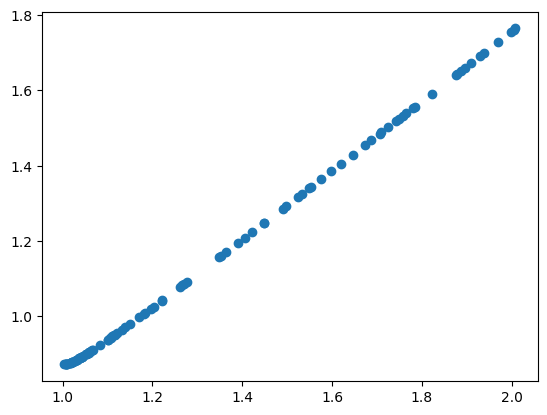

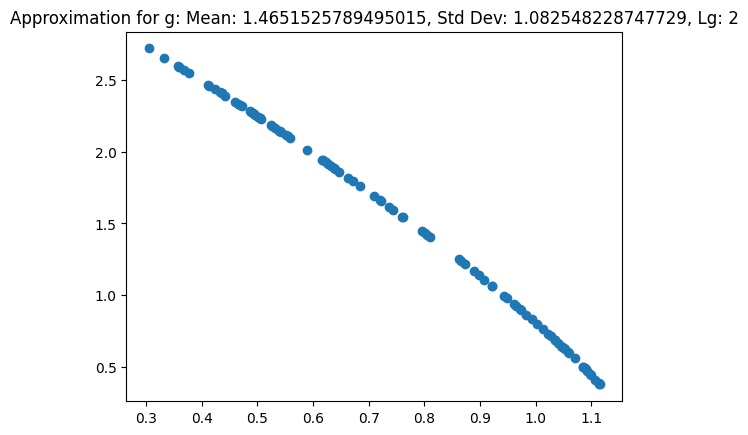

In [372]:
def mu(x):
    return 1+x**2 #np.mean(x)*np.ones(len(x))

def sigma(x):
    return np.std(x)


# prior
mu_test = mu((x_test)) # mean
sigma_test = sigma((x_test)) # std. dev

# posterior 
# mu_test = mu(g(x_test)) # mean
# sigma_test = sigma(g(x_test)) # std. dev

P_test = r(x_test, x_test, sigma_test, l=2) # unsure if x_i = x_j = x_train

#print(f'P_Test: {P_test}')
#print(f'mu_Test: {mu_test}')
#print(f'size: Ptest: {np.shape(P_test)}')
n_samples = 20

Y0 = stats.multivariate_normal(mean = mu_test,cov = P_test, allow_singular= True).rvs(n_samples)
#print(f'Y0 shape: {np.shape(Y0)}')

slope, intercept, r_value, p_value, std_err = stats.linregress(Y0[0],Y0[1])

print(f'R-value: {r_value}')

plt.scatter(Y0[0], Y0[1])
plt.show()



### OPTIMAL PARAMS FOR g:
mu_g = 1.4651525789495015
sigma_g = 1.082548228747729
l_g = 2 # unsure

P_g = r(x_test, x_test, sigma_g, l=l_g)
Yg0 = stats.multivariate_normal(mean = mu_g*np.ones(len(x_test)),cov = P_g, allow_singular= True).rvs(n_samples)
plt.title(f'Approximation for g: Mean: {mu_g}, Std Dev: {sigma_g}, Lg: {l_g}')
plt.scatter(Yg0[0], Yg0[1])
plt.show()
 

## Adding data (likelihood)

In our Bayesian formulation the random-variable $\mathbf{Y} | \mathbf{d}$ (that we are trying to identify), is defined at both training- and test nodes.  Data $\mathbf{d}\in \mathbb{R}^M$ is only available at training nodes.  We need therefore:
 
1. An observation matrix $H \in \mathbb{R}^{M\times (M+N)}$, which extracts only the observed (training) values from the combined training + test vector $\mathbf{y}$.
2. The observation error matrix $R = \sigma_\epsilon^2 I\in \mathbb{R}^{M\times M}$ - whereby we assume Gaussian uncorrellated observation errors.  We assume throughout that $\sigma_\epsilon=1\times 10^{-3}$.

**EXERCISE 3**

Implement 1: There is a useful trick here: Numpy *slices*.  With the syntax `x_all[:M]` you extract the 1st `M` entries of `x_all`.  Similarly `x_all[M:]` returns all except the 1st `M` entries.  Apply this idea to an identity matrix of size $M+N$ to get a suitable matrix $H$.

Implement 2. As well as $R$, also evaluate the data $\mathbf{d} := g(\mathbf{x}_\mathrm{train}) + \epsilon$.  I.e. explicitly add a small about of noise to the observations to simulate a real measurement.  Use `stats.multivariate_normal(0*x_train, R).rvs()` to generate the noise.

In [380]:
# observation matrix
def calc_H(x_all, y_all, M, N):
    H = np.eye(M+N)
    H = H[:M, :]

    x_observation, y_observation = x_all[:M], y_all[:M]
    H_observation = np.cov(np.hstack((x_all, y_all)))

    H[:M, :M] = H_observation
    
    return H

# observation error matrix
def calc_R(M, sigma_e = 1e-3):
    return sigma_e**2*np.eye(M)

**EXERCISE 4**

Now implementing Kriging is just a question of computing the posterior pdf from Bayes rule:
$$
p( \mathbf{y} \mid \mathbf{d}) \propto p(\mathbf{d}\mid  \mathbf{y}) \cdot p_0(\mathbf{y}).
$$
Since prior and likelihood are both Gaussian, the posterior is Gaussian
$$
\mathbf{Y} \mid \mathbf{d} \sim \mathcal{N}(\hat\mu, \hat\Sigma),
$$
and we need only find the mean and covariance matrix - which is just linear algebra:
$$
\hat\mu = \mu_y + K (\mathbf{d} - H\mu_y) \\
\hat\Sigma = (I - K H) P \\
K = PH^T (R+HPH^T)^{-1}.
$$
Beware that in this formula, the prior mean $\mu_0$ and covariance $P$ should be evaluated at *all* nodes.

Plot the mean, and a few random samples from the posterior.  Compare with the true function.  [For plotting using only the test nodes is convenient.]  You should see a good fit at the training nodes, and closeby - especially where training nodes are clustered.  The fit elsewhere may be poor.  Choose reasonable values for $\mu()$ and $\sigma_0$ given what you know about the function - adjust $l$ to try to get a reasonable fit (it may be difficult without more than 10 samples!).

x: ((110,),)mu: (110,), K: (110, 10), d: (10,), H: (10, 110)
Mean Posterior: [-0.00926702  0.06376289  0.06267546  0.27303238  0.05769611  0.03667029
  0.40762622  0.11504068  0.74122632  0.01196836 -0.00415044  0.00192735
  0.29687592  0.01331789  1.08925244 -0.00963986  0.77654366  0.5684032
  0.36859662  1.00222867  0.00441239 -0.00875597  0.67318891 -0.0079498
  0.79014858  0.82629832 -0.00782371 -0.00318668  0.00469281  0.82128412
 -0.00216683  0.15445358 -0.00996339 -0.00999317  0.79909876  0.06363228
  0.71781604  0.00467551  0.76663     0.24452627 -0.00729032  0.00363933
  0.00835841  0.74290252  0.02927531  0.42308008  0.1438268   0.33587037
  0.02936372  1.03117354  0.63406588  0.00720785  1.0438096   0.03397442
  0.02470796  0.53657233  0.59882098 -0.00878087  0.01666604 -0.00829647
  0.31564795  0.01082462  0.36845144  1.13717987  0.01251799 -0.00342451
  0.03700644  0.2503945   0.98388193 -0.00903319  0.06390301  0.95926053
  0.00373171 -0.00832043  0.02562993 -0.0099834  

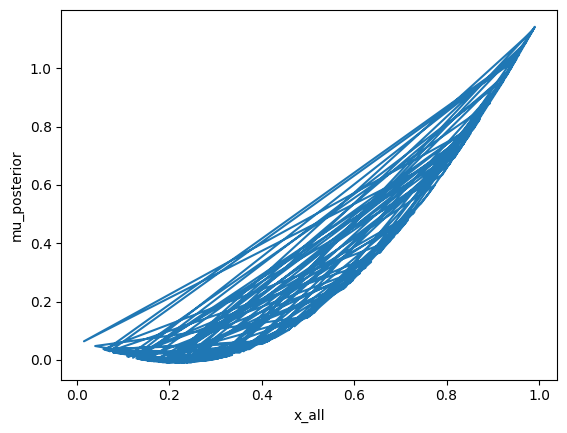

In [392]:
def calc_K(P, H, R):
    return P @ H.T @ np.linalg.inv(R + H @P @ H.T)

def calc_muPosterior(x, mu, P, H, R, d):
    K = calc_K(P, H, R)
    mu_prior = mu(x)
    print(f'x: {np.shape(x), }mu: {np.shape(mu_prior)}, K: {np.shape(K)}, d: {np.shape(d)}, H: {np.shape(H)}') #K @ (d - H @ mu_prior: {np.shape(K @ (d - H @ mu_prior))}')
    return mu_prior + K @ (d - H @ mu_prior)


def calc_sigmaPosterior(P, H, R, M, N):
    K = calc_K(P, H, R)
    return (np.eye(M+N)- K @ H) @ P

def mu(x):
    return 1+x**2


# select mean, std. dev, and support length of test function (g)
mu_g = 1.4651525789495015
sigma_g = 1.082548228747729
l_g = 1 # modify manually 


y_all = g(x_all)
y_train = g(x_train)

H = calc_H(x_all, y_all, M, N)
R = calc_R(M)
P = r(x_all, x_all, sigma_g, l_g) # prior covariance matrix for ALL nodes

# muPosterior = calc_muPosterior(mu_prior = mu_g*np.ones(len(x_train)) , P = P, H = H, R = R, d = y_train)

muPosterior = calc_muPosterior(x = x_all, mu = mu, P = P, H = H, R = R, d = y_train)
Sigma_Posterior = calc_sigmaPosterior(P, H, R, M, N)


print(f'Mean Posterior: {muPosterior}')
print(f'Std. Dev. Posterior: {Sigma_Posterior}')

plt.plot(x_all, muPosterior)
plt.xlabel('x_all')
plt.ylabel('mu_posterior')

# sample posterior 
#samples = np.random.normal(loc = muPosterior, scale = Sigma_Posterior, size = 10)
pass

# compare with function (g)
pass

**EXERCISE 5**

Take your code so far, and (without much modification), put in a form which can be called in the following way.  Check results are similar to your previous code.

In [396]:
def kriging(M, N, x, d, mu, sigma_0 = 1.082548228747729, sigma_epsilon = 1e-3, l = 1):
    """
    Kriging in 1-dimension for a single variable - following the
    Bayesian derivation and notation.
    
    Arguments:
      M,N [integers]: Number of training-, test-nodes.
      x [array (M+N)]: Node locations (both observations and predictions)
      d [array (M)]: Nodal observations ("data")
      mu [function]: Mean of prior.
      sigma_0 [float]: Standard-deviation of the prior.
      sigma_epsilon [float]: Standard-deviation of observation error.
      l [float]: Correlation length.
    Return:
      muhat [array (M+N)]: Posterior mean
      Sigmahat [array (M+N,M+N)]: Posterior covariance.
    """
    H = calc_H(x, d, M, N)
    R = calc_R(M)
    P = r(x, x, sigma_0, l)

    muhat = calc_muPosterior(x, mu, P = P, H = H, R = R, d = d)
    Sigmahat = calc_sigmaPosterior(P, H, R, M, N)
    return muhat[M:], Sigmahat[M:]

def mu(x):
    return 1+x**2


muhat, Sigmahat = kriging(x = x_all, d = y_train, M = 10, N = 100, mu = mu, sigma_0 = 1.082548228747729, sigma_epsilon = 1e-3, l = 1)
    

x: ((110,),)mu: (110,), K: (110, 10), d: (10,), H: (10, 110)


## Convergence study
**EXERCISE 6**

The most basic thing we require from numerical methods is *convergence*.  The following code will test the convergence of your `kriging()` function.  For an error measure the RMSE w.r.t. the kriging mean, at the test nodes is used:
$$
\epsilon := \sqrt{\frac{1}{N}\sum_{i=1}^N (g(\mathbf{x}_i) - \hat\mu(\mathbf{x}_i))^2}
$$
Both training and test-nodes are uniformly spaced to reduce noise.  You can see the variability in convergence by running `convergence_study()` multiple times in the cell below, which will add more lines to the same graph.

Which of the 3 parameters $\mu$, $\sigma_0$, $l$ is the most important for the convergence rate and absolute error?  What happens to the converenge for large values of $M$?  It should approach a constant *rate*? (I.e. straight-line in log-log plot.)  Is this rate familiar?  Why is does this rate result eventually?

x: ((1004,),)mu: (1004,), K: (1004, 4), d: (4,), H: (4, 1004)
x: ((1008,),)mu: (1008,), K: (1008, 8), d: (8,), H: (8, 1008)
x: ((1016,),)mu: (1016,), K: (1016, 16), d: (16,), H: (16, 1016)
x: ((1032,),)mu: (1032,), K: (1032, 32), d: (32,), H: (32, 1032)
x: ((1064,),)mu: (1064,), K: (1064, 64), d: (64,), H: (64, 1064)
x: ((1128,),)mu: (1128,), K: (1128, 128), d: (128,), H: (128, 1128)
x: ((1256,),)mu: (1256,), K: (1256, 256), d: (256,), H: (256, 1256)
x: ((1512,),)mu: (1512,), K: (1512, 512), d: (512,), H: (512, 1512)
x: ((2024,),)mu: (2024,), K: (2024, 1024), d: (1024,), H: (1024, 2024)
x: ((3048,),)mu: (3048,), K: (3048, 2048), d: (2048,), H: (2048, 3048)
Convergence rate = -1.237
x: ((1004,),)mu: (1004,), K: (1004, 4), d: (4,), H: (4, 1004)
x: ((1008,),)mu: (1008,), K: (1008, 8), d: (8,), H: (8, 1008)
x: ((1016,),)mu: (1016,), K: (1016, 16), d: (16,), H: (16, 1016)
x: ((1032,),)mu: (1032,), K: (1032, 32), d: (32,), H: (32, 1032)
x: ((1064,),)mu: (1064,), K: (1064, 64), d: (64,), H: (

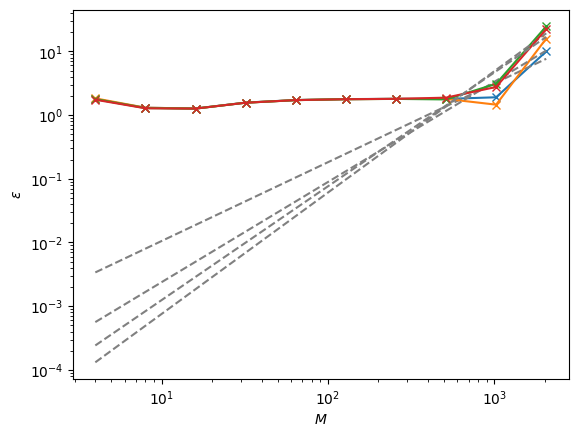

In [397]:
# Convergence study
def mu(x):
    return 1+x**2   # TODO pick a reasonable prior
sigma_0 = 1.082548228747729 # TODO pick a reasonable std. dev
l = 1 # TODO pick a reasonable correlation length
sigma_epsilon = 1.e-3

def convergence_study(mu, sigma_0, sigma_epsilon, l):
    N = 1000
    # Ms = 2**np.arange(2,12,dtype=np.int)
    Ms = 2**np.arange(2,12,dtype=int)
    err_M = np.zeros(len(Ms))
    for j,M in enumerate(Ms):
        x = np.hstack((np.linspace(0,1,M), np.linspace(0,1,N)))
        d = g(x[:M]) + stats.multivariate_normal(np.zeros(M), np.identity(M)*sigma_epsilon**2).rvs()
        muhat,_ = kriging(M, N, x, d, mu, sigma_0, sigma_epsilon, l)
        err_M[j] += np.sqrt(np.sum((g(x[M:]) - muhat)**2)/N)

    plt.loglog(Ms, err_M, 'x-')

    plt.xlabel(r'$M$')
    plt.ylabel(r'$\epsilon$')
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(np.log10(Ms)[-3:], np.log10(err_M)[-3:])
    print("Convergence rate = %.4g" % -slope)
    plt.loglog(Ms, 10**(intercept + slope*np.log10(Ms)), '--', color='0.5')   

    
convergence_study(mu, sigma_0, sigma_epsilon, l/4)
convergence_study(mu, sigma_0, sigma_epsilon, l/2)
convergence_study(mu, sigma_0, sigma_epsilon, l)
convergence_study(mu, sigma_0, sigma_epsilon, 2*l)

